In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


Crossvalidating robust_scaler
Crossvalidating standard_scaler
Crossvalidating min_max_scaler
Crossvalidating no_scaling


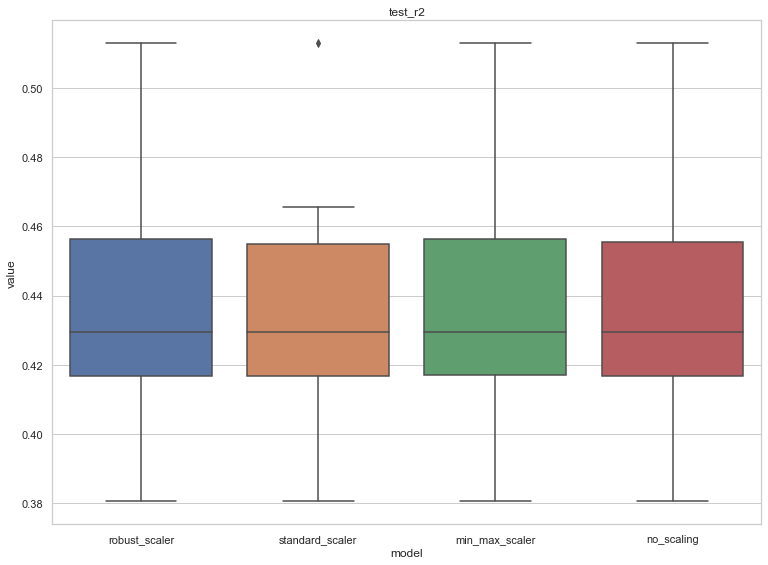

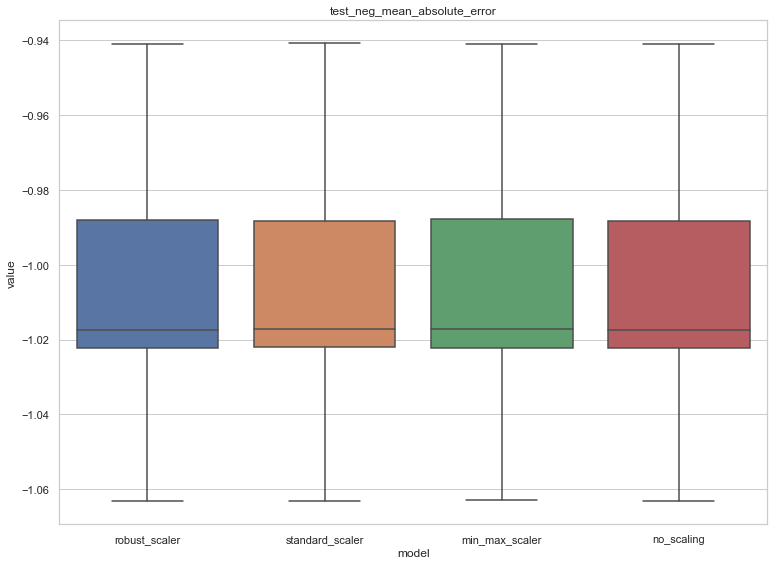

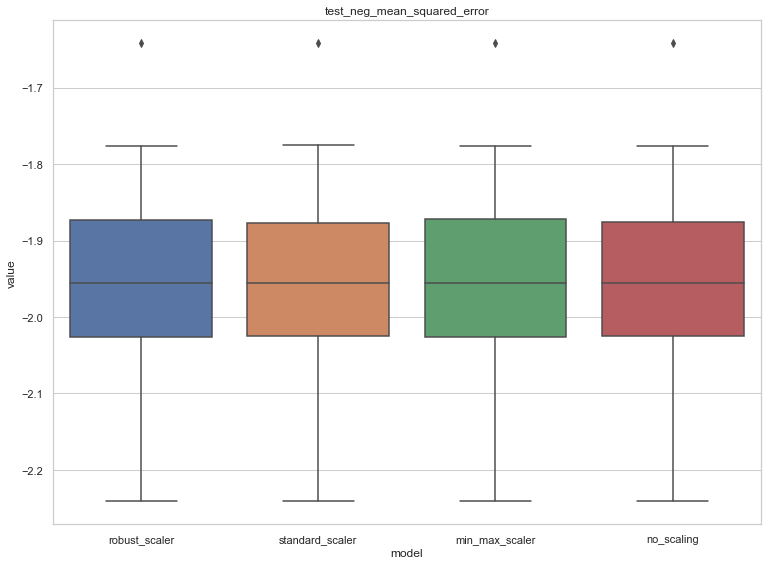

In [9]:

scores = crossvalidate_pipeline_scores(
    X=X_train,
    y=y_train,
    pipelines=scaler_pipelines,
    n_splits=10,
    random_state=random_state,
)

plot_scores(scores=scores)


In [10]:

import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bayes_opt import BayesianOptimization
from dotenv import find_dotenv, load_dotenv
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, ShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler,
                                   RobustScaler, StandardScaler)

from src.visualization.visualize import (crossvalidate_pipeline_scores,
                                         plot_scores,
                                         train_and_plot_prediction_metrics)

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123



 # Optimizing the Hyperparameters for Model Without Feature Selection

 * Using scoring metric of mean squared error and bayesian optimization

In [11]:


def gradient_boosting_cv(
    max_depth,
    min_samples_split,
    min_samples_leaf,
    max_features,
):
    pipeline = make_pipeline(
        VarianceThreshold(),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=int(max_features),
        ),
    )
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, cv=3, scoring="neg_mean_squared_error",
        n_jobs=3
    )
    return cv_scores.mean()


parameter_bounds = {
    "max_depth": (4, 7),
    "min_samples_split": (2, 100),
    "min_samples_leaf": (4, 10),
    "max_features": (3, X_train.shape[1]),
}

optimizer = BayesianOptimization(
    f=gradient_boosting_cv,
    pbounds=parameter_bounds,
    verbose=2,
    random_state=random_state,
)

optimizer.maximize(init_points=50, n_iter=100)
print(optimizer.max)



|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
|  1        | -3.201    |  6.089    |  10.15    |  5.361    |  56.03    |
|  2        | -3.19     |  6.158    |  13.58    |  9.885    |  69.11    |
|  3        | -3.2      |  5.443    |  12.8     |  6.059    |  73.45    |
|  4        | -3.281    |  5.316    |  4.492    |  6.388    |  74.32    |
|  5        | -3.252    |  4.547    |  7.386    |  7.189    |  54.12    |
|  6        | -3.187    |  5.903    |  24.24    |  8.347    |  61.88    |
|  7        | -3.197    |  6.167    |  11.07    |  6.171    |  24.37    |
|  8        | -3.194    |  4.881    |  18.77    |  4.553    |  44.5     |
|  9        | -3.192    |  5.293    |  15.34    |  6.555    |  32.6     |
|  10       | -3.187    |  5.279    |  25.33    |  9.665    |  51.18    |
|  11       | -3.264    |  5.872    |  5.89     |  5.904    |  42.65    |
|  12       | -3.203    |  6.599    | 

In [24]:

selector = RFECV(
    GradientBoostingRegressor(
        learning_rate=0.001,
        n_estimators=100,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=4,
        # max_features=3,
    ),
    step=1,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=3,
)
selector = selector.fit(X_train, y_train)
columns_to_keep = X_train.columns[selector.support_]
print("Columns to keep:", columns_to_keep)
print(
    "Proportion of features kept:",
    round(len(columns_to_keep) * 100 / len(X_train.columns), 1),
    "%",
)



Columns to keep: Index(['iphone', 'samsunggalaxy', 'googleandroid', 'iphonecampos',
       'samsungcampos', 'iphonecamneg', 'iphonecamunc', 'iphonedispos',
       'iphonedisneg', 'samsungdisneg', 'iphonedisunc', 'samsungdisunc',
       'iphoneperpos', 'samsungperpos', 'samsungperneg'],
      dtype='object')
Proportion of features kept: 53.6 %


In [26]:


def gradient_boosting_cv(max_depth, min_samples_split, min_samples_leaf, max_features):
    pipeline = make_pipeline(
        VarianceThreshold(),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=int(max_features),
        ),
    )
    cv_scores = cross_val_score(
        pipeline,
        X_train[columns_to_keep],
        y_train,
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=3,
    )
    return cv_scores.mean()


parameter_bounds = {
    "max_depth": (4, 7),
    "min_samples_split": (2, 100),
    "min_samples_leaf": (4, 10),
    "max_features": (3, X_train[columns_to_keep].shape[1]),
}

optimizer = BayesianOptimization(
    f=gradient_boosting_cv,
    pbounds=parameter_bounds,
    verbose=2,
    random_state=random_state,
)

optimizer.maximize(init_points=50, n_iter=50)
print(optimizer.max)



|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
|  1        | -3.199    |  6.089    |  6.434    |  5.361    |  56.03    |
|  2        | -3.187    |  6.158    |  8.077    |  9.885    |  69.11    |
|  3        | -3.198    |  5.443    |  7.705    |  6.059    |  73.45    |
|  4        | -3.262    |  5.316    |  3.716    |  6.388    |  74.32    |
|  5        | -3.23     |  4.547    |  5.105    |  7.189    |  54.12    |
|  6        | -3.187    |  5.903    |  13.19    |  8.347    |  61.88    |
|  7        | -3.192    |  6.167    |  6.876    |  6.171    |  24.37    |
|  8        | -3.191    |  4.881    |  10.57    |  4.553    |  44.5     |
|  9        | -3.191    |  5.293    |  8.924    |  6.555    |  32.6     |
|  10       | -3.187    |  5.279    |  13.72    |  9.665    |  51.18    |
|  11       | -3.223    |  5.872    |  4.387    |  5.904    |  42.65    |
|  12       | -3.198    |  6.599    | 

 # Performance of the optimized models

Crossvalidating default_model
Crossvalidating default_model_feature_selection
Crossvalidating optimized_model_for_no_feature_selection
Crossvalidating optimized_model_for_no_feature_feature_selection
Crossvalidating optimized_model
Crossvalidating optimized_model_feature_selection


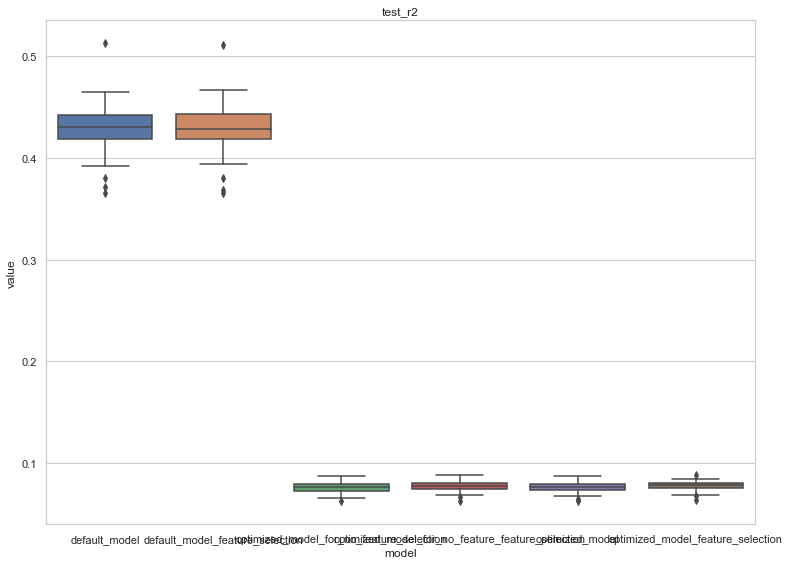

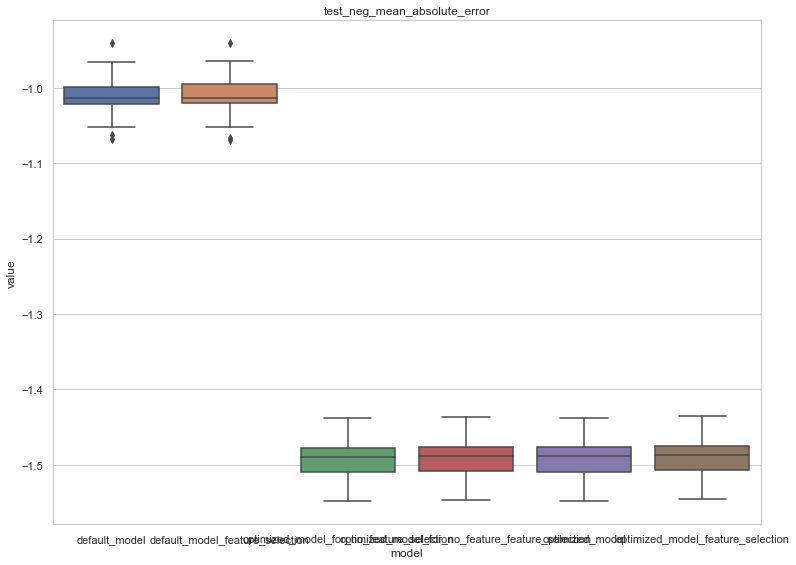

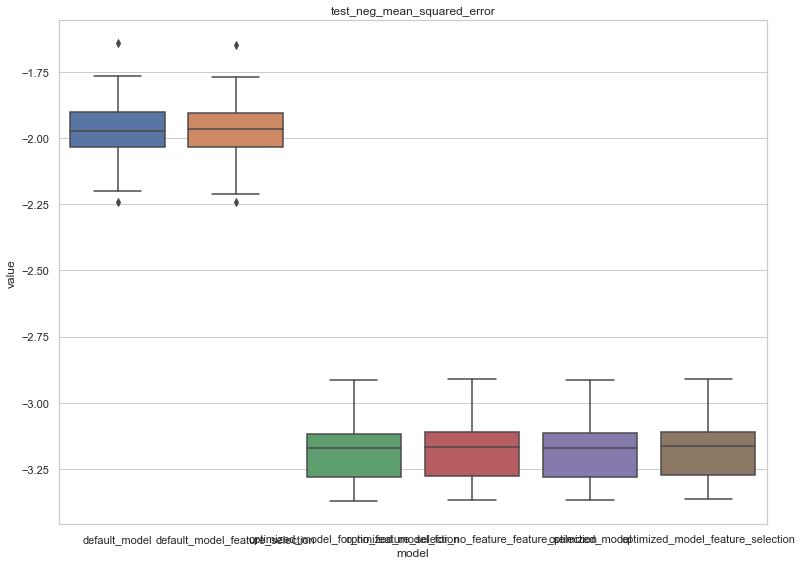

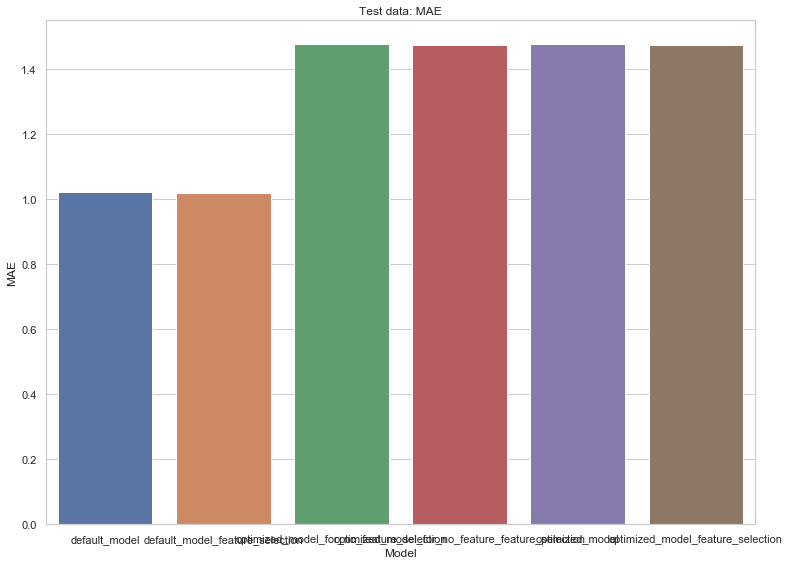

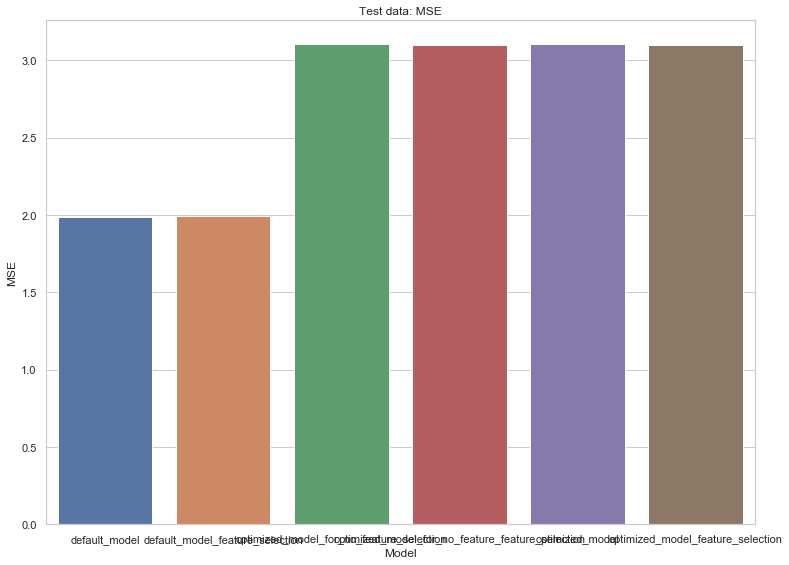

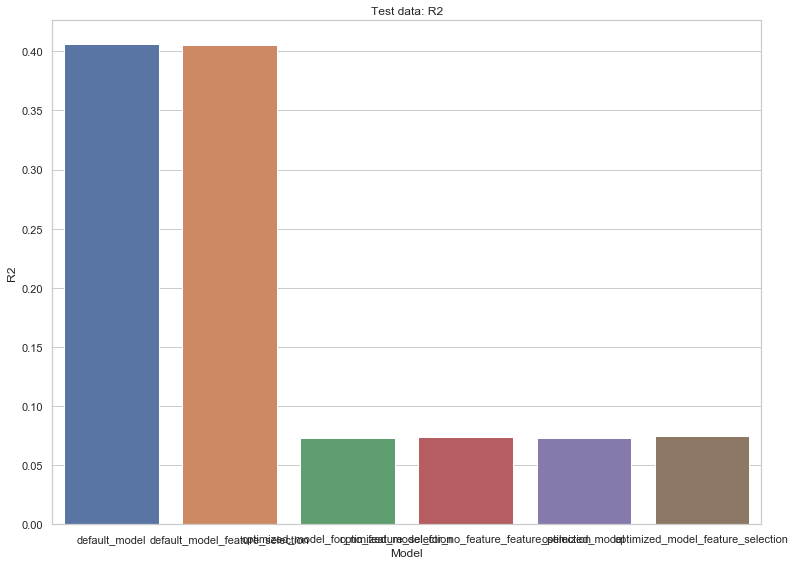

In [28]:


def drop_preselected_columns(X):
    return X[:, selector.support_]


final_pipelines = {
    "default_model": make_pipeline(VarianceThreshold(), GradientBoostingRegressor()),
    "default_model_feature_selection": make_pipeline(
        VarianceThreshold(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        GradientBoostingRegressor(),
    ),
    "optimized_model_for_no_feature_selection": make_pipeline(
        VarianceThreshold(),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=6,
            min_samples_split=2,
            min_samples_leaf=4,
            max_features=15,
        ),
    ),
    "optimized_model_for_no_feature_feature_selection": make_pipeline(
        VarianceThreshold(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=6,
            min_samples_split=2,
            min_samples_leaf=4,
            max_features=15,
        ),
    ),
    "optimized_model": make_pipeline(
        VarianceThreshold(),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=7,
            min_samples_split=95,
            min_samples_leaf=10,
            max_features=15,
        ),
    ),
    "optimized_model_feature_selection": make_pipeline(
        VarianceThreshold(),
        FunctionTransformer(drop_preselected_columns, validate=False),
        GradientBoostingRegressor(
            learning_rate=0.001,
            n_estimators=100,
            max_depth=7,
            min_samples_split=95,
            min_samples_leaf=10,
            max_features=15,
        ),
    ),
}

scores_optimized = crossvalidate_pipeline_scores(
    X=X_train,
    y=y_train,
    pipelines=final_pipelines,
    n_splits=30,
    random_state=random_state,
)

plot_scores(scores=scores_optimized)

train_and_plot_prediction_metrics(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    pipelines=final_pipelines,
)

